### Uncertainty reduction in homogenization problems, Part-3
This notebook is similar to [Part-1](https://github.com/helalme/DataDrivenMSE/tree/master/UncertaintyReductionInHomogenization), however, the LSTM model is not unidirectional, but it is bidirectional LSTM here. 

#### Necesary modules

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


#### ETL process

In [0]:
from google.colab import files
import io
uploaded = files.upload()

Saving RVEsize-Homogenization1.txt to RVEsize-Homogenization1.txt


In [0]:
#Reading Dataset, input is cubic RVE size in oneDirection, output isAveraged sigma33 for 20 time steps
dataset= np.loadtxt(io.BytesIO(uploaded['RVEsize-Homogenization1.txt'])) 

RVEsize =  dataset[0]
series= dataset[1:]
series = np.transpose(series)
series

array([[-3.85728372e+01, -5.49696605e+01, -6.75108209e+01,
        -7.80635725e+01, -8.73350760e+01, -9.56729234e+01,
        -1.03271046e+02, -1.10247634e+02, -1.16681362e+02,
        -1.22629082e+02, -9.01058811e+01, -5.71779755e+01,
        -2.38770753e+01,  9.76832072e+00,  4.37326010e+01,
         7.79922094e+01,  1.12525554e+02,  1.47312661e+02,
         1.82335075e+02,  2.17575669e+02],
       [-3.01645182e+01, -4.24959971e+01, -5.17744379e+01,
        -5.94965060e+01, -6.62278128e+01, -7.22595870e+01,
        -7.77656075e+01, -8.28585971e+01, -8.76157425e+01,
        -9.20917255e+01, -5.82982513e+01, -2.42931169e+01,
         9.90116280e+00,  4.42671268e+01,  7.87909101e+01,
         1.13461358e+02,  1.48269068e+02,  1.83206352e+02,
         2.18266220e+02,  2.53442698e+02],
       [-2.29372278e+01, -3.22702133e+01, -3.92435865e+01,
        -4.50476037e+01, -5.01266838e+01, -5.47012760e+01,
        -5.88988089e+01, -6.28006302e+01, -6.64623979e+01,
        -6.99241136e+01, -3.5

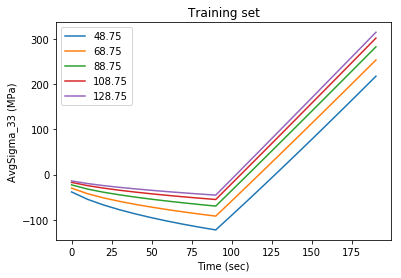

In [0]:
time=range(0,200,10)
plt.plot(time, series[0],  label='48.75')
plt.plot(time, series[1],  label='68.75')
plt.plot(time, series[2],  label='88.75')
plt.plot(time, series[3],  label='108.75')
plt.plot(time, series[4],  label='128.75')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training set')
plt.legend()

plt.show()

### Start bidirectional LSTM, with 2-to-1 architecture

In [0]:
Xtrain=np.array([[series[0],series[1]],[series[1],series[2]],[series[2],series[3]]])
Ytrain = np.array([series[2],series[3],series[4]])
print(Xtrain)
print(Ytrain)

Xtrain.shape

[[[-3.85728372e+01 -5.49696605e+01 -6.75108209e+01 -7.80635725e+01
   -8.73350760e+01 -9.56729234e+01 -1.03271046e+02 -1.10247634e+02
   -1.16681362e+02 -1.22629082e+02 -9.01058811e+01 -5.71779755e+01
   -2.38770753e+01  9.76832072e+00  4.37326010e+01  7.79922094e+01
    1.12525554e+02  1.47312661e+02  1.82335075e+02  2.17575669e+02]
  [-3.01645182e+01 -4.24959971e+01 -5.17744379e+01 -5.94965060e+01
   -6.62278128e+01 -7.22595870e+01 -7.77656075e+01 -8.28585971e+01
   -8.76157425e+01 -9.20917255e+01 -5.82982513e+01 -2.42931169e+01
    9.90116280e+00  4.42671268e+01  7.87909101e+01  1.13461358e+02
    1.48269068e+02  1.83206352e+02  2.18266220e+02  2.53442698e+02]]

 [[-3.01645182e+01 -4.24959971e+01 -5.17744379e+01 -5.94965060e+01
   -6.62278128e+01 -7.22595870e+01 -7.77656075e+01 -8.28585971e+01
   -8.76157425e+01 -9.20917255e+01 -5.82982513e+01 -2.42931169e+01
    9.90116280e+00  4.42671268e+01  7.87909101e+01  1.13461358e+02
    1.48269068e+02  1.83206352e+02  2.18266220e+02  2.5344

(3, 2, 20)

#### Lets explore with bidirectional 2-to-1 architecture, with a single bidirectional LSTM layer
So there will be three sets of (X,Y) or 3 features.


In [0]:
Xtrain.shape

(3, 2, 20)

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<.1) : #and logs.get('val_loss')<.5 
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,activation='relu',  return_sequences=True, input_shape=(2, 20))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',input_shape=(2, 20))),  
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(Xtrain, Ytrain, epochs=1000, callbacks=[callbacks])

Train on 3 samples
Epoch 1/1000
3/3 [==============================] - 2s 830ms/sample - loss: 16763.3770
Epoch 2/1000
3/3 [==============================] - 0s 6ms/sample - loss: 8778.4619
Epoch 3/1000
3/3 [==============================] - 0s 4ms/sample - loss: 6115.3359
Epoch 4/1000
3/3 [==============================] - 0s 4ms/sample - loss: 3525.9016
Epoch 5/1000
3/3 [==============================] - 0s 4ms/sample - loss: 2264.4631
Epoch 6/1000
3/3 [==============================] - 0s 4ms/sample - loss: 892.3522
Epoch 7/1000
3/3 [==============================] - 0s 4ms/sample - loss: 1297.5856
Epoch 8/1000
3/3 [==============================] - 0s 4ms/sample - loss: 976.0467
Epoch 9/1000
3/3 [==============================] - 0s 4ms/sample - loss: 1052.2184
Epoch 10/1000
3/3 [==============================] - 0s 3ms/sample - loss: 800.0622
Epoch 11/1000
3/3 [==============================] - 0s 4ms/sample - loss: 598.7869
Epoch 12/1000
3/3 [==============================] - 0s 

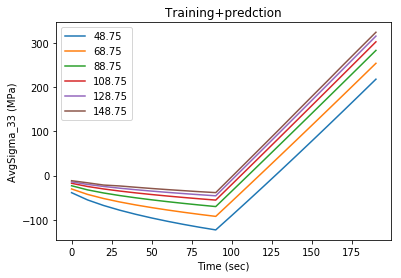

In [0]:
prediction1=np.array([series[3],series[4]])
prediction1= prediction1.reshape((1,prediction1.shape[0], prediction1.shape[1]))
pred148_75=model.predict(prediction1)

#prediction2=np.array([series[4],pred148_75[0]])
#prediction2= prediction2.reshape((1,prediction2.shape[0], prediction2.shape[1]))
#pred168_75=model.predict(prediction2)

time=range(0,200,10)
plt.plot(time, series[0],  label='48.75')
plt.plot(time, series[1],  label='68.75')
plt.plot(time, series[2],  label='88.75')
plt.plot(time, series[3],  label='108.75')
plt.plot(time, series[4],  label='128.75')
plt.plot(time, pred148_75[0],  label='148.75')
#plt.plot(time, pred168_75[0],  label='168.75')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+predction')
plt.legend()

plt.show()

#### Remarks: It seems a single layer bidirectional LSTM is better than any architecture of unidirectional one, training is more stable and convergence is faster.

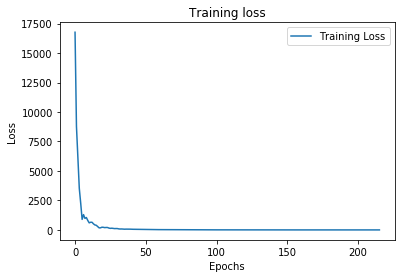

In [0]:
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs[0:], loss[0:],  label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()

plt.show()

#### Lets see the next prediction,  prediction seems just great. 

In [0]:
Xtrain1=np.array([[series[0],series[1]],[series[1],series[2]],[series[2],series[3]],[series[3],series[4]]])
Ytrain1 = np.array([series[2],series[3],series[4],pred148_75[0]])

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<.05) : #and logs.get('val_loss')<.5 
      print("\nReached expected accuracy level, so cancelling training!")
      self.model.stop_training = True
      
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,activation='relu',  return_sequences=True, input_shape=(2, 20))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',input_shape=(2, 20))),  
    tf.keras.layers.Dense(units=20)
])

#model.summary()

adamOptimizer=keras.optimizers.Adam(lr=2.5e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
MSE='mean_squared_error'
model.compile(optimizer=adamOptimizer, loss=MSE)
history = model.fit(Xtrain1, Ytrain1, epochs=1000, callbacks=[callbacks])

Train on 4 samples
Epoch 1/1000
4/4 [==============================] - 3s 644ms/sample - loss: 22370.1914
Epoch 2/1000
4/4 [==============================] - 0s 4ms/sample - loss: 12661.4238
Epoch 3/1000
4/4 [==============================] - 0s 3ms/sample - loss: 7932.4492
Epoch 4/1000
4/4 [==============================] - 0s 3ms/sample - loss: 5188.0518
Epoch 5/1000
4/4 [==============================] - 0s 3ms/sample - loss: 3521.1243
Epoch 6/1000
4/4 [==============================] - 0s 3ms/sample - loss: 2487.5791
Epoch 7/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1553.0891
Epoch 8/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1215.2849
Epoch 9/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1165.7426
Epoch 10/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1255.5703
Epoch 11/1000
4/4 [==============================] - 0s 3ms/sample - loss: 1294.2347
Epoch 12/1000
4/4 [==============================] 

#### Training and prediction dataset together, relative error is less than 1%, convergence is very fast.

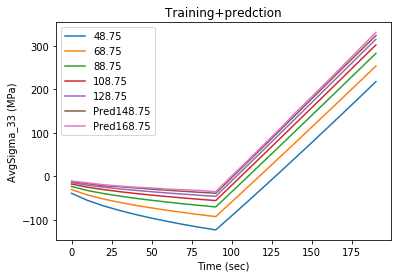

In [0]:
prediction2=np.array([series[4],pred148_75[0]])
prediction2= prediction2.reshape((1,prediction2.shape[0], prediction2.shape[1]))
pred168_75=model.predict(prediction2)

time=range(0,200,10)
plt.plot(time, series[0],  label='48.75')
plt.plot(time, series[1],  label='68.75')
plt.plot(time, series[2],  label='88.75')
plt.plot(time, series[3],  label='108.75')
plt.plot(time, series[4],  label='128.75')
plt.plot(time, pred148_75[0],  label='Pred148.75')
plt.plot(time, pred168_75[0],  label='Pred168.75')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training+predction')
plt.legend()

plt.show()

In [0]:
pred168_75

array([[-10.436793, -14.661054, -18.945835, -22.045652, -24.69054 ,
        -26.36137 , -28.917046, -30.474792, -32.16388 , -34.88139 ,
          1.131721,  36.658592,  73.33767 , 109.10865 , 147.424   ,
        183.00839 , 219.61954 , 256.5306  , 293.7165  , 330.88852 ]],
      dtype=float32)